In [1]:
import os, time
from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imageio

import itertools
import pickle

from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch

# For progress
from tqdm import trange, tqdm, tnrange, tqdm_notebook
from time import sleep


In [2]:
use_gpu = cuda.is_available()
# use_gpu=False

# Learning to generate MNIST digits using a De-Convolutional Generator Discriminator model

In [3]:
class Generator(nn.Module):
    # Initialize with random variables from normal distribution    
    def weight_init(self, mean, std):
        for i in self._modules:
            if isinstance(self._modules[i], nn.ConvTranspose2d):
                self._modules[i].weight.data.normal_(mean, std)
                self._modules[i].bias.data.zero_()
                
    def __init__(self, n_channels=100, init=True, reuse=False, mean=0.0, std=0.02 ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.ConvTranspose2d(in_channels=n_channels, # "Deconvolutional" layer 
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            # output layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.Tanh()
        )
        if init: self.weight_init(mean, std)
            
    def forward(self, x):
        output = self.main(x)
        return output

In [4]:
class Discriminator(nn.Module):
    # Initialize with random variables from normal distribution    
    def weight_init(self, mean, std):
        for i in self._modules:
            if isinstance(self._modules[i], nn.Conv2d):
                self._modules[i].weight.data.normal_(mean, std)
                self._modules[i].bias.data.zero_()
                
    def __init__(self, reuse=False, n_channels=1, init=True, mean=0.0, std=0.02):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.Conv2d(in_channels=n_channels,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            
            #output layer
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.Sigmoid()
            
        )
        if init: self.weight_init(mean, std)
                
    def forward(self, y):
        output = self.main(y)
        return output
        

In [5]:
# G = Generator().cuda()
# for i in range(5): imshow(torchvision.utils.make_grid(G(Variable(torch.rand([10, 100, 1, 1])).cuda()).data))
# D = Discriminator().cuda()
# print(D(G(Variable(torch.rand([1, 100, 1, 1])).cuda())))


In [6]:
# define transform
def get_data(img_size = 64, batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform, )
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1 )
    # train_data_iter = iter(torch.Tensor(trainloader))
#     testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#     testloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1 )

    classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
    return trainloader, classes

torch.Size([128, 1, 64, 64])


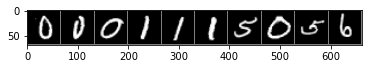

  0   0   0   1   1   1   5   0   5   6


In [7]:
def imshow(img, use_gpu=use_gpu):
    if use_gpu: img=img.cpu()
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
trainloader, classes = get_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images, labels = images[0:10], labels[0:10]

imshow(torchvision.utils.make_grid(images, nrow=10))
print(" ".join("%3s" % classes[labels[j]] for j in range(len(labels))))

In [8]:
def g_sampler(batch_size):
    return torch.randn([batch_size, 100, 1, 1])
# print(g_sampler().size())
# print(g_sampler().squeeze())

In [9]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
if not os.path.isdir('DCGAN_MNIST_results'):
    os.mkdir('DCGAN_MNIST_results')
if not os.path.isdir('DCGAN_MNIST_results/generated'):
    os.mkdir('DCGAN_MNIST_results/generated')

In [11]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [12]:
fixed_input = torch.randn(16, 100, 1, 1)
fixed_input = Variable(fixed_input, volatile=True)
if use_gpu: fixed_input = fixed_input.cuda()

def show_generated(epoch, path, save=True, show=False):
    G.eval()
    test_images = G(fixed_input)
    G.train()
    
    fig, ax = plt.subplots(4, 4, figsize=(4, 4))
    for i, j in itertools.product(range(4), range(4)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
    for i in range(16):
        j = i // 4
        k = i % 4
        ax[j, k].cla()
        ax[j, k].imshow(test_images[i, 0].cpu().data.numpy(), cmap='gray')
    
    label = 'Epoch {0}'.format(epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)
    
    if show:
        plt.show()
    else:
        plt.close()


In [13]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [14]:
def training(G, D, criterion, d_optimizer, g_optimizer, g_sampler, batch_size=128, num_epochs=20, epoch_int=10, d_steps=1, g_steps=1, use_gpu=use_gpu, start_epoch=0, resume=False):
    if resume:
        if os.path.isfile("checkpoint.pth.tar"):
            print("=> loading checkpoint '{}'".format("checkpoint.pth.tar"))
            checkpoint = torch.load("checkpoint.pth.tar")
            start_epoch = checkpoint['epoch']
            G.load_state_dict(checkpoint['G_state_dict'])
            D.load_state_dict(checkpoint['D_state_dict'])
            g_optimizer.load_state_dict(checkpoint['g_optimizer'])
            d_optimizer.load_state_dict(checkpoint['d_optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format("checkpoint.pth.tar", checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    print("Image processing starting")
    
    trainloader, _ = get_data(img_size = 64, batch_size=batch_size)
    dataiter = iter(trainloader)
    
    print("Image processing complete")
    if use_gpu:
        G = G.cuda()
        D = D.cuda()
        print("GPU in use!")
    else:
        print("CPU in use :(")
    
    print("Training Starting")
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['epoch_times'] = []
    train_hist['train_time'] = []
#     print('1')
    start_time = time.time()    
    for epoch in tnrange(num_epochs-start_epoch, desc='Epoch'):
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
#         print('2')
        for j in tqdm_notebook(range(ceil(60000/batch_size)), desc='Batch', leave=False):
            if j<468: continue
                
#             print('3')
            d_real_images, _ = dataiter.next()
            batch_size_i = d_real_images.size()[0]
#             training on discriminator
            for d_i in range(d_steps):
                D.zero_grad()
#                 print('4')    
                #on real
                d_real_images = Variable(d_real_images)
                if use_gpu: d_real_images = d_real_images.cuda()
                d_real_decision = D(d_real_images)
                d_real_ones = Variable(torch.ones([batch_size_i]))
                if use_gpu: d_real_ones = d_real_ones.cuda()
                d_real_loss = criterion(d_real_decision.squeeze(), d_real_ones)
                d_real_loss.backward()
#                 print('4.1')
                # on fake
                d_gen_input = Variable(g_sampler(batch_size=batch_size_i))
                if use_gpu: d_gen_input = d_gen_input.cuda() 
                d_fake_images = G(d_gen_input).detach()
                d_fake_decision = D(d_fake_images)
                d_fake_zeros = Variable(torch.zeros([batch_size_i]))
                if use_gpu: d_fake_zeros = d_fake_zeros.cuda()
                d_fake_loss = criterion(d_fake_decision.squeeze(), d_fake_zeros)
                
                d_fake_loss.backward()
                d_optimizer.step()
#                 print('4.5')
                d_loss = d_fake_loss + d_real_loss
                D_losses.append(d_loss.data[0])
#             training on generator            
            for g_i in range(g_steps):
                G.zero_grad()
#                 print('5')    
                gen_input = Variable(g_sampler(batch_size=batch_size_i))
                if use_gpu: gen_input = gen_input.cuda()
                g_fake_images = G(gen_input)
                fake_decision = D(g_fake_images)
                fake_decision_ones = Variable(torch.ones([batch_size_i]))
                if use_gpu: fake_decision_ones = fake_decision_ones.cuda()
                g_loss = criterion(fake_decision.squeeze(), fake_decision_ones)
                
                g_loss.backward()
                g_optimizer.step()
                G_losses.append(g_loss.data[0])
#         print('6')
        # Save Checkpoint
        save_checkpoint({
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'g_optimizer' : g_optimizer.state_dict(),
            'd_optimizer' : d_optimizer.state_dict(),
        })
        p = 'DCGAN_MNIST_results/generated/DCGAN_MNIST_' + str(epoch + 1) + '.png'
        show_generated((epoch+1), save=True, path=p)
        
        
        epoch_end_time = time.time()   
        epoch_time = epoch_end_time - epoch_start_time
        
        # Saving Epoch data
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
        train_hist['epoch_times'].append(epoch_time)
        
        epoch_time = time.strftime("%M mins %S secs", time.gmtime(epoch_time))
        print("%2s/%2s - epochTime: %10s | "%(epoch+1, num_epochs, epoch_time))
                
        imshow(torchvision.utils.make_grid(g_fake_images.data[0:3]))
    
    end_time = time.time()
    train_time = end_time-start_time
    train_hist['train_time'].append(train_time)
    train_time_s = time.strftime("%H hrs %M mins %S secs", time.gmtime(train_time))
    
    with open('DCGAN_MNIST_results/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)
    
    print("Training Time: %s"%(train_time_s))
    print("Training Complete!")
    
    show_train_hist(train_hist, save=True, path='DCGAN_MNIST_results/DCGAN_MNIST_train_hist.png')

    images = []
    for e in range(num_epochs):
        img_name = 'DCGAN_MNIST_results/generated/DCGAN_MNIST_' + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave('DCGAN_MNIST_results/generation_animation.gif', images, fps=5)
    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % (torch.mean(torch.FloatTensor(train_hist['epoch_times'])), num_epochs, train_time))

Image processing starting
Image processing complete
GPU in use!
Training Starting


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


 1/20 - epochTime: 00 mins 05 secs | 


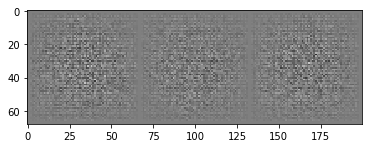

Widget Javascript not detected.  It may not be installed or enabled properly.


 2/20 - epochTime: 00 mins 05 secs | 


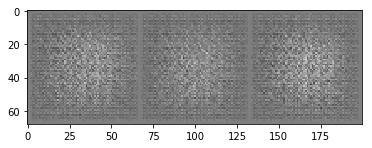

Widget Javascript not detected.  It may not be installed or enabled properly.


 3/20 - epochTime: 00 mins 05 secs | 


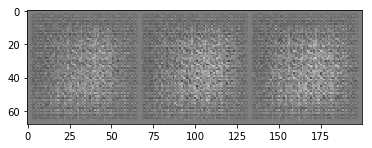

Widget Javascript not detected.  It may not be installed or enabled properly.


 4/20 - epochTime: 00 mins 05 secs | 


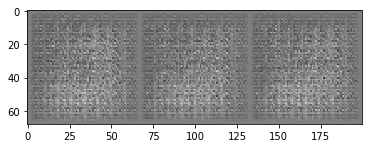

Widget Javascript not detected.  It may not be installed or enabled properly.


 5/20 - epochTime: 00 mins 05 secs | 


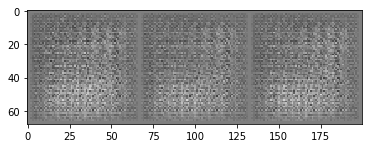

Widget Javascript not detected.  It may not be installed or enabled properly.


 6/20 - epochTime: 00 mins 06 secs | 


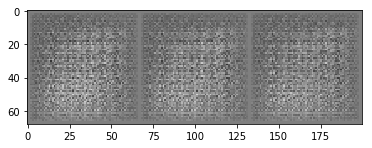

Widget Javascript not detected.  It may not be installed or enabled properly.


 7/20 - epochTime: 00 mins 07 secs | 


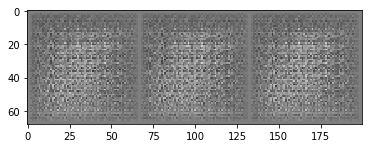

Widget Javascript not detected.  It may not be installed or enabled properly.


 8/20 - epochTime: 00 mins 06 secs | 


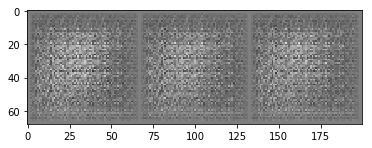

Widget Javascript not detected.  It may not be installed or enabled properly.


 9/20 - epochTime: 00 mins 06 secs | 


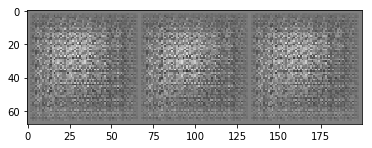

Widget Javascript not detected.  It may not be installed or enabled properly.


10/20 - epochTime: 00 mins 05 secs | 


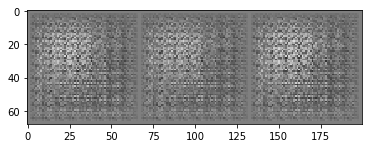

Widget Javascript not detected.  It may not be installed or enabled properly.


11/20 - epochTime: 00 mins 05 secs | 


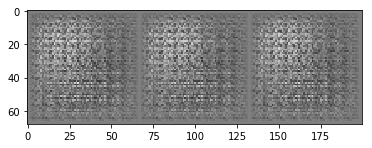

Widget Javascript not detected.  It may not be installed or enabled properly.


12/20 - epochTime: 00 mins 05 secs | 


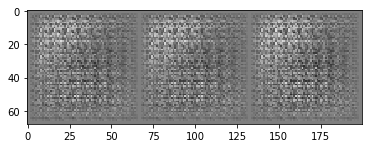

Widget Javascript not detected.  It may not be installed or enabled properly.


13/20 - epochTime: 00 mins 06 secs | 


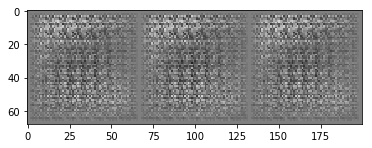

Widget Javascript not detected.  It may not be installed or enabled properly.


14/20 - epochTime: 00 mins 05 secs | 


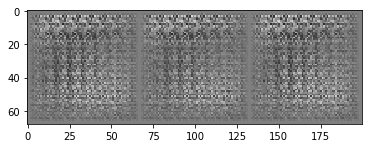

Widget Javascript not detected.  It may not be installed or enabled properly.


15/20 - epochTime: 00 mins 05 secs | 


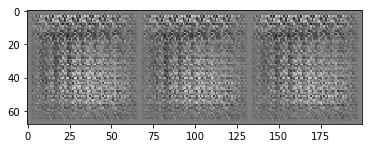

Widget Javascript not detected.  It may not be installed or enabled properly.


16/20 - epochTime: 00 mins 05 secs | 


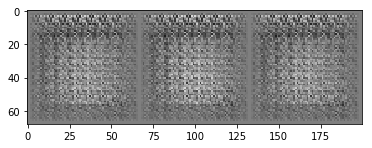

Widget Javascript not detected.  It may not be installed or enabled properly.


17/20 - epochTime: 00 mins 05 secs | 


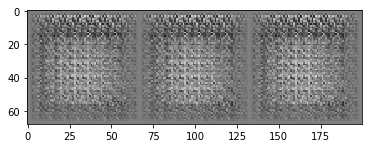

Widget Javascript not detected.  It may not be installed or enabled properly.


18/20 - epochTime: 00 mins 07 secs | 


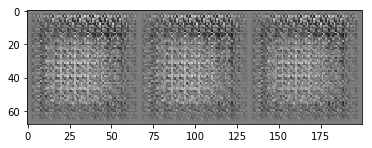

Widget Javascript not detected.  It may not be installed or enabled properly.


19/20 - epochTime: 00 mins 06 secs | 


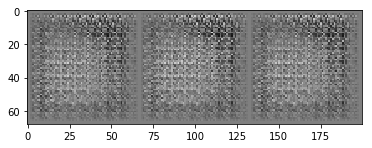

Widget Javascript not detected.  It may not be installed or enabled properly.


20/20 - epochTime: 00 mins 06 secs | 


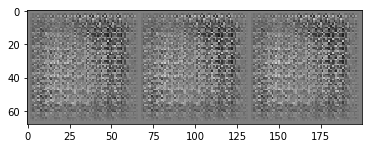


Training Time: 00 hrs 02 mins 05 secs
Training Complete!
Avg per epoch time: 6.13, total 20 epochs time: 125.87


In [15]:
training(G=G,
         D=D,
         criterion=criterion,
         d_optimizer=d_optimizer,
         g_optimizer=g_optimizer,
         g_sampler=g_sampler,
         batch_size=128,
         num_epochs=20,
         epoch_int=1,
#          resume=True
        )

In [16]:
torch.cuda.empty_cache()

## References:
- https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f
- http://pytorch.org/docs/0.3.0/
- https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN
- https://github.com/carpedm20/DCGAN-tensorflow
- https://github.com/devnag/pytorch-generative-adversarial-networks
- https://github.com/pytorch/examples/tree/master/dcgan
- https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN

### TODO:
- **DONE** Make GPU ready
- **DONE** Fix training to use all data.
- **DONE** Add Noise.
- **DONE** Collect Data during training.
- **DONE** Use data collected to make graphs
- **DONE** Output graphs to directory
- **DONE** Save training values
- Add gan mean and variance data capture and graph
